This is a test notebook for the Gaussian Diffusion peptide project. To test if the model is working, I will give it a synthetic dataset (a sin wave) and check if the diffusion model can diffuse into that:

In [114]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn
import time

from torch.utils.data import DataLoader, TensorDataset
from guided_diffusion.guided_diffusion_1d import Unet1D, GaussianDiffusion1D
device = "cuda" if torch.cuda.is_available() else "cpu"

In [46]:
SEQ_LENGTH = 128 # number of entries in the latent
FREQ_THRESH = 10

In [131]:
# Creates the synthetic dataset which is just a bunch of sin waves
def create_wave(freq, phase, seq_length):
    # creates a wave with freq, phase, and seq_length (the number of samples in the wave)
    t = np.linspace(0, 1, seq_length)

    # normalizes wave to [0, 1]
    latent = ((np.sin(freq * t + phase) / 2) + 0.5).reshape(-1, seq_length) 
    return torch.tensor(latent, dtype=torch.float32)

def is_high_frequency(freq):
    return 1 if freq >= FREQ_THRESH else 0

class SyntheticDataset(Dataset):
    def __init__(self, num_samples=1000, seq_length=128):
        self.num_samples = num_samples
        self.seq_length = seq_length
        self.create_dataset()

    def create_dataset(self):
        self.latents = []
        self.freqs = []
        self.labels = []

        # creates num_sample random sin waves
        for _ in range(self.num_samples):
            freq = np.random.uniform(6, 40.0)
            phase = np.random.uniform(0, 2 * np.pi)
            self.latents.append(create_wave(freq, phase, self.seq_length))
            self.freqs.append(freq)
            self.labels.append(is_high_frequency(freq))

    def __len__(self):
        return len(self.latents)

    def __getitem__(self, idx):
        return self.latents[idx]            
    
    def get_latents(self):
        return self.latents
    
    def get_freq(self, idx):
        return self.freqs[idx]

In [124]:
def plot_latent(x):
    z = x.reshape(-1)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(np.linspace(0, 1, SEQ_LENGTH), z, 'b-', linewidth=2)

def plot_sample(samples, num_samples=4):
        b, c, n = samples.shape
        
        # Plot the samples
        plt.figure(figsize=(12, 8))
        for i in range(num_samples):
            plt.subplot(num_samples, 1, i+1)
            plt.plot(np.linspace(0, 1, n), samples[i, 0].cpu().numpy())
            plt.title(f"Sample {i+1}")
            plt.ylim(0, 1.1)
        plt.tight_layout()
    

Freq: 19.651093924435592, Label: 1
Freq: 15.069295065475227, Label: 1
Freq: 6.486138190648431, Label: 0
Freq: 34.28701913960686, Label: 1


/var/folders/1b/k5nxn8c5129gq34kmfvprrj40000gn/T/ipykernel_80043/4732451.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  self.latents.append(np.array(create_wave(freq, phase, self.seq_length), dtype=float))


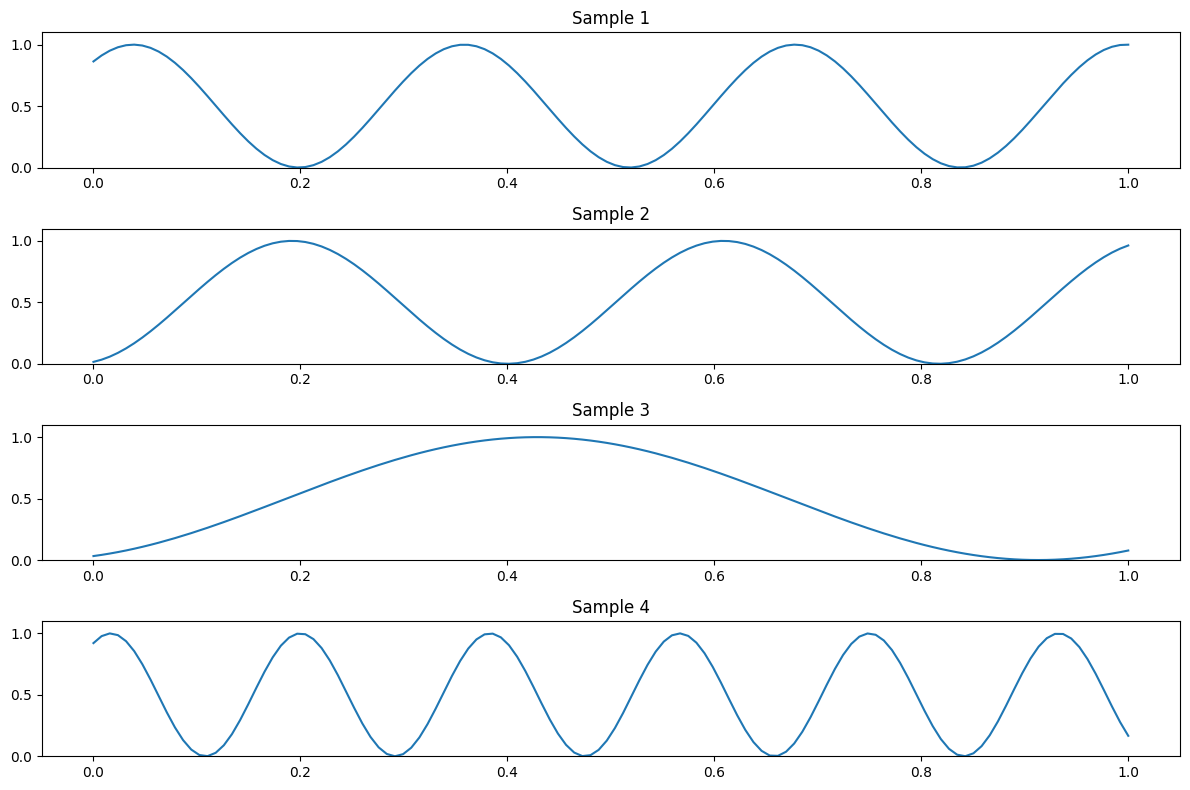

In [125]:
dataset = SyntheticDataset(num_samples=1000, seq_length=128)
samples = torch.tensor([dataset.latents[i] for i in range(4)])
plot_sample(samples=samples, num_samples=4)
for i in range(4):
    print(f"Freq: {dataset.freqs[i]}, Label: {dataset.labels[i]}")

In [126]:
def train_diffusion(model, dataset, batch_size=16, epochs=10, lr=1e-4):
    model = model.to(device)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        start_time = time.time()
        
        for batch_idx, batch in enumerate(dataloader):
            batch = batch.to(device)
            
            optimizer.zero_grad()
            loss = model(batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if batch_idx % 10 == 0:
                print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.6f}")
        
        avg_loss = epoch_loss / len(dataloader)
        elapsed = time.time() - start_time
        print(f"Epoch {epoch} completed. Avg Loss: {avg_loss:.6f}, Time: {elapsed:.2f}s")

        model.eval()
        with torch.no_grad():
            samples = model.sample(batch_size=4)
            plot_sample(samples)



In [130]:
class SimpleClassifier(nn.Module):
    def __init__(self, channels=1, seq_length=128):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(64 * (seq_length // 4), 128)
        self.fc2 = nn.Linear(128, 1)  # Binary classifier (high/low frequency)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze(-1)

def train_classifier(dataset : SyntheticDataset, seq_length=128, channels=1, batch_size=16, epochs=50):
    
    # Create dataloader


    latents = torch.stack([torch.from_numpy(latent) for latent in dataset.latents])
    dataset = TensorDataset(latents.float(), torch.tensor(dataset.labels).float())  # Changed to stack scalars
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # classifier
    classifier = SimpleClassifier(channels=channels, seq_length=seq_length)
    
    # optimizer
    optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()
    
    # train classifier loop
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    classifier.to(device)
    
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            x, y = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            outputs = classifier(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Classifier Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.6f}")
        test_classifier(classifier)


    
    return classifier


dataset = SyntheticDataset(num_samples=1000, seq_length=128)
classifier = train_classifier(dataset, seq_length=128, channels=1)

/var/folders/1b/k5nxn8c5129gq34kmfvprrj40000gn/T/ipykernel_80043/4732451.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  self.latents.append(np.array(create_wave(freq, phase, self.seq_length), dtype=float))


[[8.35284710e-01 7.89216578e-01 7.39114523e-01 6.85677350e-01
  6.29650414e-01 5.71815133e-01 5.12978196e-01 4.53960240e-01
  3.95584434e-01 3.38665009e-01 2.83995837e-01 2.32339427e-01
  1.84416309e-01 1.40894860e-01 1.02382146e-01 6.94153160e-02
  4.24541757e-02 2.18747873e-02 7.96418171e-03 9.16381890e-04
  8.29688506e-04 7.70531083e-03 2.14473493e-02 4.18641344e-02
  6.86708912e-02 1.01493739e-01 1.39874861e-01 1.83278918e-01
  2.31100544e-01 2.82672703e-01 3.37276101e-01 3.94149154e-01
  4.52498555e-01 5.11510551e-01 5.70361912e-01 6.28231943e-01
  6.84313416e-01 7.37824142e-01 7.88017750e-01 8.34194124e-01
  8.75709236e-01 9.11984026e-01 9.42512572e-01 9.66869056e-01
  9.84713793e-01 9.95797813e-01 9.99966502e-01 9.97161865e-01
  9.87422884e-01 9.70885396e-01 9.47780192e-01 9.18429375e-01
  8.83242428e-01 8.42710078e-01 7.97397733e-01 7.47937322e-01
  6.95018709e-01 6.39380097e-01 5.81797361e-01 5.23073792e-01
  4.64028358e-01 4.05484647e-01 3.48259240e-01 2.93150276e-01
  2.4092

In [120]:
def test_classifier(classifier):
    dataset = SyntheticDataset(num_samples=1000, seq_length=128)

    succ = 0
    classifier.eval()
    for i in range(1000):
        latent_tensor = torch.from_numpy(dataset.latents[i]).float().reshape(1, 1, SEQ_LENGTH)
        prob = torch.sigmoid(classifier(latent_tensor))
        if (prob[0].item() >= 0.5) == (dataset.labels[i]):
            succ += 1
    print(f"Correctness: {succ / 1000}")
    
test_classifier(classifier)

Correctness: 0.989


In [ ]:
batch_size = 16
num_datapoints = 1000
epochs = 5
seq_length = SEQ_LENGTH

print(f"Using device: {device}")
dataset = SyntheticDataset(num_samples=num_datapoints, seq_length=seq_length)
# latents = torch.stack([torch.from_numpy(latent).float() for latent in dataset.latents])

model = Unet1D(
    dim=128,
    channels=1,
    dim_mults=(1, 2, 4)
)

diffusion = GaussianDiffusion1D(
    model,
    seq_length=seq_length,
    timesteps=50,
    objective='pred_v'
)

# see what it looks like before training
with torch.no_grad():
    model.eval()
    samples = diffusion.sample(batch_size=4)
    plot_sample(samples)
train_diffusion(diffusion, dataset, epochs=epochs)


Using device: cpu


sampling loop time step: 100%|██████████| 50/50 [00:00<00:00, 59.51it/s]


Epoch 0, Batch 0, Loss: 0.494174
Epoch 0, Batch 10, Loss: 0.186524


In [ ]:
    
# def classifier_guidance_fn(x, t, classifier, guidance_scale=1.0):
#     """
#         Compute the gradient of the classifier score with respect to x
#     """
#     x.requires_grad_(True)
#     score = classifier(x)
#     grad = torch.autograd.grad(score.sum(), x)[0]

#     return guidance_scale * grad

In [ ]:
def sample_with_guidance(diffusion, classifier, guidance_scale=5.0, batch_size=4, seq_length=128, channels=1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create a partial function for guidance
    def cond_fn(x, t):
        with torch.enable_grad():
            y = torch.fill(torch.zeros(batch_size), 0).long()
            x_in = x.detatch().requires_grad_(True)
            logits = classifier(x_in)
            log_probs = F.log_softmax(logits, dim = -1)
            selected = log_probs[range(len(logits))]
            grad = torch.autograd.grad(selected.sum(), x_in)[0] * guidance_scale
            return grad
        
    # Sample with guidance
    samples = diffusion.sample(
        batch_size=batch_size,
        cond_fn=cond_fn,
        guidance_kwargs={}
    )
    
    # Also generate samples without guidance for comparison
    with torch.no_grad():
        samples_no_guidance = diffusion.sample(batch_size=batch_size)
    
    return samples, samples_no_guidance
samples, samples_no_guidance = sample_with_guidance(diffusion, classifier)
plot_sample(samples_no_guidance)
plot_sample(samples)

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]


AttributeError: 'Tensor' object has no attribute 'detatch'